#### Copyright IBM All Rights Reserved.

# Using the IBM Db2 Augmented Data Explorer REST API

This notebook includes basic Python examples for the REST API to Db2 Augmented Data Explorer and uses Db2 as a data source for exploring data.

Every business is interested in getting more business and adopts different strategies to upsell and cross-sell to its custmers. For this purpose the business collects and analyzes purchase patterns, demographic information to identify spending, visiting and purchasing patterns. 
In this notebook we will be looking at database called `ADEDEMO` with a focus on the `Customers` table.

**Objective** Get insights for `Average Money Spent` for the *customers*
1. Find any relationships between `Average Money Spent` with `Gender`, `Education`, `Age` or `Marital Status` etc.
2. How is `Average Money Spent` related to `Number of Purchaes` and `Days Since Last Purchase`?

## Prerequisites:
1. Python 3.6 and above
2. Db2 on Cloud instance (using free-tier option)
3. Data already loaded in your Db2 instance
4. Db2 connection credentials on hand

## Required libraries

To run the examples in this notebook, you need to install the following libraries:

- `requests`: For making HTTP calls.
- `matplotlib`: For visualizing the results.

We also use the `pandas` library. This library should already be installed if you are able to use this notebook.

## 1. Setting up

We are going to import the required libraries and create a variable that stores the base URL for the REST API. Update this variable to a value that matches your environment.

In [251]:
from IPython.core.display import display, HTML
import pandas as pd
import matplotlib
import requests
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import webbrowser
import re
import json

base_url = "http://localhost:5000/api/v1"

## 2. Getting authenticated

All the API endpoints are protected. You must be authorized as a system administrator to access all the endpoints in this notebook. Here we are authenticating with the default user, who has the correct privileges. The API responds with an access token.

### Authentication

In [252]:
account_username = "admin"
account_password = "password"

In [ ]:
auth_json = {"username": account_username, "password": account_password}

auth_resp = requests.post(f"{base_url}/sessions", json=auth_json)

print(auth_resp.json())

To make it easier to make subsequent calls with the prop authorization, we will create a header variable with the token.

In [254]:
header = {"Authorization": f"Bearer {auth_resp.json()['token']}"}

## 3. Setting up connections

Db2 Augmented data explorer works with Db2 databases. If you haven't already set up a connection using the browser interface, you must create one now. Following is a sample connection. Before running this cell, update the variables at the beginning of the cell with values that match your connection.

In [269]:
conn_types = requests.get(f"{base_url}/connection-types", headers=header)
conn_array = json.loads(conn_types.content)

In [ ]:
conn_array

In [ ]:
connection_type_guid = conn_array['connection_types'][1]['guid']

In [ ]:
connection_type_guid

In [ ]:
hostname    = "dashdb-txn-sbox-yp-lon02-02.services.eu-gb.bluemix.net"
username    = "hnd97781"
password    = "***"
schema_name = "HND97781"
database    = "BLUDB"

connection_json = {
  "connection_type_guid": connection_type_guid,
  "configuration": {
    "hostname": hostname,
    "database": database,
    "port": "50000",
    "protocol": "TCPIP",
    "user": username,
    "password": password,
    "autocommit": False
  },
  "schemas_to_crawl": [
    {
      "schema": schema_name,
      "crawl_all_tables": True,
      "selected_tables": []
    }
  ]
}

connection_resp = requests.post(f"{base_url}/connections", json=connection_json, headers=header)

print(connection_resp.json())

## 4. Crawling

Before you can search or get results from Db2 Augmented Data Explorer, you need to crawl the connection that you set up previously. The crawling process connects to the database and stores information about the data in an Elasticsearch index.

In [48]:
crawl_json = {
    "status": "crawling"
}

crawl_resp = requests.put(f"{base_url}/status", json=crawl_json, headers=header)

print(crawl_resp.json())

{'message': 'Crawling started. Use GET /api/v1/status to check the crawling status.'}


As indicated by the response, you can continue to poll the `/status` endpoint to check the progress of the crawling process.

In [130]:
status_resp = requests.get(f"{base_url}/status", json=crawl_json, headers=header)

print(status_resp.json())

{'build': '1789', 'version': '0.9.0', 'overall_health': 'green', 'overall_health_last_updated': '2019-12-05T11:30:20.967375', 'overall_last_message': 'Everything looks good!', 'crawling': False, 'crawling_since': None, 'crawl_health': 'green', 'crawl_health_last_updated': '2019-12-05T11:30:20.599990', 'crawl_last_message': 'Crawling completed', 'crawl_pct_complete': 100, 'cache_health': 'green', 'cache_health_last_updated': '2019-12-05T11:30:20.967349', 'cache_last_message': '', 'ds_health': 'green', 'ds_health_last_updated': '2019-12-05T11:30:20.965236', 'ds_last_message': ''}


When `'crawling'` is `False`, crawling is complete and we can start searching.

## 5. Search & Suggest - Get Natural Language Insights

Searching in Db2 Augmented Data Explorer involves sending searching text and getting back query suggestions for the search text. These suggestions are valid query objects, which you can use to get data. 

To get data and natural language insights, we combine the `/suggestions` and `/results` endpoints in the `get_first_result` function to return the first suggestion.

### Get First Result
Combines search and suggestions endpoints to get the first result

In [260]:
def get_first_result(search_text):
    search_json = {
        "search_text": search_text,
        "plain_text": True
    }

    search_resp = requests.post(f"{base_url}/suggestions", json=search_json, headers=header)

    if not "suggestions" in search_resp.json():
        return {}

    results_response = requests.post(f"{base_url}/results", json=search_resp.json()['suggestions'][0], headers=header)

    return results_response.json()

### Search Text
You can change the text `Avg_Money_Spent by` to anything of your choice.

In [261]:
results_response = get_first_result("Avg_Money_Spent by Age")

In [182]:
results_response = get_first_result("Avg_Money_Spent by Gender")

In [296]:
results_response = get_first_result("INCIDENT_ZIP by BOROUGH")

In [293]:
results_response = get_first_result("INCIDENT_ZIP by COMPLAINT_TYPE")


In [294]:
results_response

{'data': '[{"COMPLAINT_TYPE":"AGENCY","AVERAGE_INCIDENT_ZIP":null},{"COMPLAINT_TYPE":"APPLIANCE","AVERAGE_INCIDENT_ZIP":10764.18},{"COMPLAINT_TYPE":"CONSTRUCTION","AVERAGE_INCIDENT_ZIP":10740.81},{"COMPLAINT_TYPE":"DOOR\\/WINDOW","AVERAGE_INCIDENT_ZIP":10702.14},{"COMPLAINT_TYPE":"ELECTRIC","AVERAGE_INCIDENT_ZIP":10809.32},{"COMPLAINT_TYPE":"ELEVATOR","AVERAGE_INCIDENT_ZIP":10669.93},{"COMPLAINT_TYPE":"Electric","AVERAGE_INCIDENT_ZIP":10032.0},{"COMPLAINT_TYPE":"FLOORING\\/STAIRS","AVERAGE_INCIDENT_ZIP":10696.45},{"COMPLAINT_TYPE":"GENERAL","AVERAGE_INCIDENT_ZIP":10656.91},{"COMPLAINT_TYPE":"GENERAL CONSTRUCTION","AVERAGE_INCIDENT_ZIP":10759.38},{"COMPLAINT_TYPE":"General","AVERAGE_INCIDENT_ZIP":10343.75},{"COMPLAINT_TYPE":"HEAT\\/HOT WATER","AVERAGE_INCIDENT_ZIP":10720.82},{"COMPLAINT_TYPE":"HEATING","AVERAGE_INCIDENT_ZIP":10742.63},{"COMPLAINT_TYPE":"HPD Literature Request","AVERAGE_INCIDENT_ZIP":null},{"COMPLAINT_TYPE":"NONCONST","AVERAGE_INCIDENT_ZIP":10803.22},{"COMPLAINT_TYPE":"O

In [297]:
display(HTML( '<font size="+1" color="blue">' + results_response['nlg'] +' </font>'))

#### Remove all special characters from text 

In [298]:
t1 = re.sub('<[^>]+>', '', results_response['nlg'])
t2 = t1.replace('\n', '#')
t3 = t2.split("#")

In [281]:
t3[1]

'The maximum average value is 11383.22, which corresponds to QUEENS.'

#### Send text to 'Alexa'

In [266]:
url = 'http://api.voicerss.org/?key=470e8ddb6e06416a8bdd7335a23be8f4&hl=en-us&src='+ t3[0]
webbrowser.open(url)

True

In [300]:
url = 'http://api.voicerss.org/?key=470e8ddb6e06416a8bdd7335a23be8f4&hl=en-us&src='+ t3[1]
webbrowser.open(url)

True

In [152]:
url = 'http://api.voicerss.org/?key=470e8ddb6e06416a8bdd7335a23be8f4&hl=en-us&src='+ t3[2]
webbrowser.open(url)

True

In [ ]:
url = 'http://api.voicerss.org/?key=470e8ddb6e06416a8bdd7335a23be8f4&hl=en-us&src='+ t3[3]
webbrowser.open(url)

In [299]:
url = 'http://api.voicerss.org/?key=470e8ddb6e06416a8bdd7335a23be8f4&hl=en-us&src='+ t3[4]
webbrowser.open(url)

True

### Plots

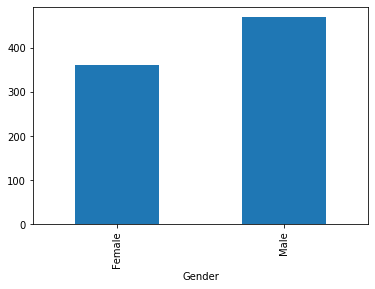

In [185]:
dataframe = pd.read_json(results_response['data'])
#my_colors = 'rgbkymc'
dataframe.plot(x = 'Gender',y = 'AVERAGE_Avg_Money_Spent',kind='bar',legend=False,
               color=['tab:blue', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])

### Get Result
Combines search and suggestions endpoints to specify which result.

In [186]:
def get_result(search_text,i):
    """ Parameters: Search Text with quotes e.g. "Avg_Money_Spent by" 
    and results response number e.g. 0
    """
    search_json = {
        "search_text": search_text,
        "plain_text": True
    }

    search_resp = requests.post(f"{base_url}/suggestions", json=search_json, headers=header)

    if not "suggestions" in search_resp.json():
        return {}

    results_response = requests.post(f"{base_url}/results", json=search_resp.json()['suggestions'][i], headers=header)

    return results_response.json()

In [187]:
results_response = get_result("Avg_Money_Spent by",3)
display(HTML(results_response['nlg']))

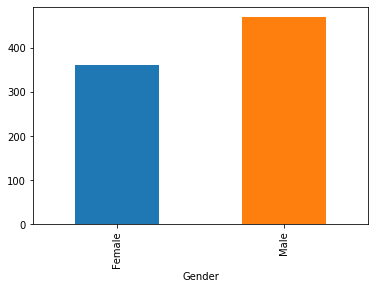

In [188]:
results_response = get_first_result("Avg_Money_Spent by Gender")
dataframe = pd.read_json(results_response['data'])
#dataframe.columns #To check column names

#x and y axis are the name of fields in the dataframe 
dataframe.plot(x = 'Gender',y = 'AVERAGE_Avg_Money_Spent',kind='bar',legend=False,
               color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])

### ADE Insights
Using *Statistical detectors* and *Natural Language Generation* we quickly know `Average Money Spent` has:
- Strong relationship with Customer Value
- No meaningful relationship with Month
- Weak relationship with region and state
- Moderate relationship with education

## 6. Visualization
Let's display this data and the related insights.

In [200]:
results_response = get_result("Avg_Money_Spent by",6) # Response 6 for Region
dataframe = pd.read_json(results_response['data'])
dataframe.head()

,Education,AVERAGE_Avg_Money_Spent
0,0 = some high school,277.37
1,1 = high school graduate,318.37
2,2 = some college,437.38
3,3 = trade/technical/vocational training,486.37
4,4 = college graduate,488.61


In [201]:
display(HTML(results_response['nlg']))

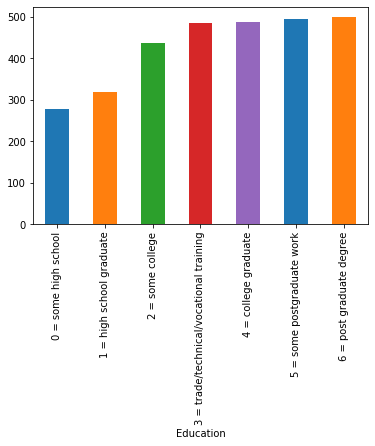

In [202]:
dataframe.plot(x = 'Education',y = 'AVERAGE_Avg_Money_Spent',kind='bar',legend=False,
              color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])

In [203]:
dataframe.plot(x = 'Region',y = 'AVERAGE_Avg_Money_Spent',kind='bar',legend=False,
              color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])

KeyError: 'Region'

## 7. Additional Analysis
How is `Average Money Spent` related to `Number of Purchaes` and `Days Since Last Purchase`?

In [204]:
search_json = {
    "search_text": "Avg_Money_Spent, Days_Since_Last_Purchase, Number_of_Purchases",
    "plain_text": True
}

search_resp = requests.post(f"{base_url}/suggestions", json=search_json, headers=header)
print(search_resp.json())

{'suggestions': [{'query': {'select': [{'fields': [{'field': 'Days_Since_Last_Purchase'}, {'field': 'Avg_Money_Spent'}, {'field': 'Number_of_Purchases'}]}], 'table': 'HND97781.CUSTOMERS', 'tables': ['HND97781.CUSTOMERS'], 'connection_guid': '9b00a165-6d50-5166-a959-86fc0853993a'}, 'text': {'short_text': 'Days_Since_Last_Purchase, Avg_Money_Spent, and Number_of_Purchases', 'long_text': 'Days_Since_Last_Purchase, Avg_Money_Spent, and Number_of_Purchases from HND97781.CUSTOMERS'}, 'hash': '9690a72434c219576c695a0040b21d070da66578'}]}


In [205]:
results_response = requests.post(f"{base_url}/results", json=search_resp.json()['suggestions'][0], headers=header)
results_response.json()
dataframe = pd.read_json(results_response.json()['data'])

#### Insights
Based on the clusters, customers can be categorized into three categories
1. Churned, infrequent penny-pinchers
2. Active, frequent big-spenders 
3. At-risk, frequent spenders

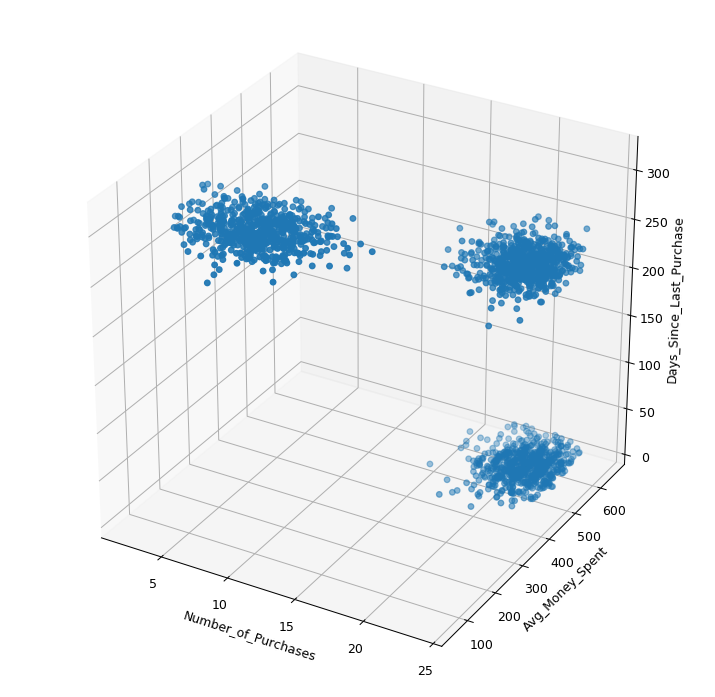

In [206]:
ThreeDPlot = plt.figure(figsize=(10, 10), dpi=90).gca(projection='3d')
ThreeDPlot.scatter(dataframe['Number_of_Purchases'], dataframe['Avg_Money_Spent'], dataframe['Days_Since_Last_Purchase'])
ThreeDPlot.set_xlabel('Number_of_Purchases')
ThreeDPlot.set_ylabel('Avg_Money_Spent')
ThreeDPlot.set_zlabel('Days_Since_Last_Purchase')
plt.show()

Blog for this code https://ibm.co/Db2ADE_SM1

To find more blogs on ADE (https://medium.com/tag/augmented-data-explorer)